In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset,Dataset, DataLoader,random_split
from PIL import Image  
import os   
from torchvision import transforms
import numpy as np
import cv2
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

class MyData(TensorDataset):
    def __init__(self, root_dir, data_dir ,mask_dir):
        self.root_dir = root_dir
        self.data_dir = data_dir
        self.mask_dir = mask_dir
        path = os.path.join(self.root_dir, self.data_dir)
        self.img_list = os.listdir(path)  
 
    def __getitem__(self, idx):
        img_name = self.img_list[idx]

        img_item_path = os.path.join(self.root_dir, self.data_dir, img_name)
        mask_item_path = os.path.join(self.root_dir, self.mask_dir, img_name)
 
        img = Image.open(img_item_path)
        mask = Image.open(mask_item_path)     
        mask = torch.tensor(np.array(mask),dtype=torch.long).unsqueeze(0)
        trans_totensor = transforms.ToTensor()  
        trans_resize = transforms.Resize((224,224))
        img = trans_resize(trans_totensor(img)*50) 
        mask = trans_resize(mask)
        return img,mask
 
    def __len__(self):
        return len(self.img_list)
 
 
r_dir = "weizmann_horse_db"
horse_dir = "horse"
mask_dir = "mask"
horse_dataset = MyData(r_dir, horse_dir,mask_dir)
train_len=int(horse_dataset.__len__()*0.85)
test_len=horse_dataset.__len__()-train_len
train_data,test_data=random_split(horse_dataset,[train_len,test_len])
train_data[0][1].shape,#sum(sum(train_data[0][0]))

(torch.Size([1, 224, 224]),)

In [2]:
train_loader = DataLoader(dataset=train_data, batch_size=1, shuffle=True, num_workers=0, drop_last=True)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False, num_workers=0, drop_last=False)

In [3]:
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim
import torchvision.transforms as standard_transforms

import numpy as np
import glob
bce_loss = nn.BCELoss(size_average=True)

def muti_bce_loss_fusion(d0, d1, d2, d3, d4, d5, d6, labels_v):

    loss0 = bce_loss(d0,labels_v)
    loss1 = bce_loss(d1,labels_v)
    loss2 = bce_loss(d2,labels_v)
    loss3 = bce_loss(d3,labels_v)
    loss4 = bce_loss(d4,labels_v)
    loss5 = bce_loss(d5,labels_v)
    loss6 = bce_loss(d6,labels_v)

    loss = loss0 + loss1 + loss2 + loss3 + loss4 + loss5 + loss6

    return loss0, loss


C:\DL\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [4]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F


# 该卷积核模块主要是设置 空洞卷积
# Relu + BatchNormal + Conv
class REBNCONV(nn.Module):
    def __init__(self,in_ch=3,out_ch=3,dirate=1):
        super(REBNCONV,self).__init__()

        # 3x3的卷积核增加一个空洞会增加2个卷积核的宽度，padding增加2个数据的宽度，正好抵消
        # 注意 padding 核 dilation 这样写只适用于 3x3 的卷积核
        self.conv_s1 = nn.Conv2d(in_ch,out_ch,3,padding=1*dirate,dilation=1*dirate)
        self.bn_s1 = nn.BatchNorm2d(out_ch)
        self.relu_s1 = nn.ReLU(inplace=True)

    def forward(self,x):

        hx = x
        xout = self.relu_s1(self.bn_s1(self.conv_s1(hx)))

        return xout

# 上采样、下采样都可以,  如何采样取决 参数 tar的形状
## upsample tensor 'src' to have the same spatial size with tensor 'tar'
def _upsample_like(src,tar):

    src = F.upsample(src,size=tar.shape[2:],mode='bilinear') # 插值法

    return src


### RSU-7 ###
class RSU7(nn.Module):#UNet07DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU7,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1) # 第一层是为了将不标准的输入标齐 U的输入通道。

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool5 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv7 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv6d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x
        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)
        hx = self.pool5(hx5)

        hx6 = self.rebnconv6(hx)

        hx7 = self.rebnconv7(hx6)

        hx6d =  self.rebnconv6d(torch.cat((hx7,hx6),1))
        hx6dup = _upsample_like(hx6d,hx5)

        hx5d =  self.rebnconv5d(torch.cat((hx6dup,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-6 ###
class RSU6(nn.Module):#UNet06DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU6,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)

        hx6 = self.rebnconv6(hx5)


        hx5d =  self.rebnconv5d(torch.cat((hx6,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-5 ###
class RSU5(nn.Module):#UNet05DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU5,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)

        hx5 = self.rebnconv5(hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-4 ###
class RSU4(nn.Module):#UNet04DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-4F ###
class RSU4F(nn.Module):#UNet04FRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4F,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=2)
        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=4)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=8)

        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=4)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=2)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx2 = self.rebnconv2(hx1)
        hx3 = self.rebnconv3(hx2)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4,hx3),1))
        hx2d = self.rebnconv2d(torch.cat((hx3d,hx2),1))
        hx1d = self.rebnconv1d(torch.cat((hx2d,hx1),1))

        return hx1d + hxin




### U^2-Net small ###
class U2NETP(nn.Module):

    def __init__(self,in_ch=3,out_ch=1):
        super(U2NETP,self).__init__()

        self.stage1 = RSU7(in_ch,16,64)
        self.pool12 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage2 = RSU6(64,16,64)
        self.pool23 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage3 = RSU5(64,16,64)
        self.pool34 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage4 = RSU4(64,16,64)
        self.pool45 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage5 = RSU4F(64,16,64)
        self.pool56 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage6 = RSU4F(64,16,64)

        # decoder
        self.stage5d = RSU4F(128,16,64)
        self.stage4d = RSU4(128,16,64)
        self.stage3d = RSU5(128,16,64)
        self.stage2d = RSU6(128,16,64)
        self.stage1d = RSU7(128,16,64)

        self.side1 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side2 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side3 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side4 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side5 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side6 = nn.Conv2d(64,out_ch,3,padding=1)

        self.outconv = nn.Conv2d(6,out_ch,1)

    def forward(self,x):

        hx = x

        #stage 1
        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        #stage 2
        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        #stage 3
        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        #stage 4
        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        #stage 5
        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        #stage 6
        hx6 = self.stage6(hx)
        hx6up = _upsample_like(hx6,hx5)

        #decoder
        hx5d = self.stage5d(torch.cat((hx6up,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.stage4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.stage3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.stage2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.stage1d(torch.cat((hx2dup,hx1),1))


        #side output
        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = _upsample_like(d2,d1)

        d3 = self.side3(hx3d)
        d3 = _upsample_like(d3,d1)

        d4 = self.side4(hx4d)
        d4 = _upsample_like(d4,d1)

        d5 = self.side5(hx5d)
        d5 = _upsample_like(d5,d1)

        d6 = self.side6(hx6)
        d6 = _upsample_like(d6,d1)

        d0 = self.outconv(torch.cat((d1,d2,d3,d4,d5,d6),1))

        return F.sigmoid(d0), F.sigmoid(d1), F.sigmoid(d2), F.sigmoid(d3), F.sigmoid(d4), F.sigmoid(d5), F.sigmoid(d6)



In [5]:
def get_miou(pre_pic, real_pic):
    miou = 0
    pre_pic = pre_pic.round().squeeze(0)
    batch, width, height = pre_pic.shape
    for i in range(batch):
        predict = pre_pic[i]
        mask = real_pic[i]
        union = torch.logical_or(predict, mask).sum()
        inter = ((predict + mask) == 2).sum()
        if union < 1e-5:
            return 0
        miou += inter / union
    return miou / batch


def get_boundary(pic, is_mask):
    if not is_mask:
        pic = pic.round().squeeze(0).cpu().numpy().astype('float64')
    else:
        pic = pic.cpu().numpy()
    batch, width, height = pic.shape
    new_pic = np.zeros([batch, width + 2, height + 2])
    mask_erode = np.zeros([batch, width, height])
    dil = int(round(0.02 * np.sqrt(width**2 + height**2)))
    if dil < 1:
        dil = 1
    for i in range(batch):
        new_pic[i] = cv2.copyMakeBorder(pic[i],
                                        1,
                                        1,
                                        1,
                                        1,
                                        cv2.BORDER_CONSTANT,
                                        value=0)
    kernel = np.ones((3, 3), dtype=np.uint8)
    for j in range(batch):
        pic_erode = cv2.erode(new_pic[j], kernel, iterations=dil)
        mask_erode[j] = pic_erode[1:width + 1, 1:height + 1]
    return torch.from_numpy(pic - mask_erode)


def get_biou(pre_pic, real_pic):
    inter = 0
    union = 0
    pre_pic = get_boundary(pre_pic, is_mask=False)
    real_pic = get_boundary(real_pic, is_mask=True)
    batch, width, height = pre_pic.shape
    for i in range(batch):
        predict = pre_pic[i]
        mask = real_pic[i]
        inter += ((predict * mask) > 0).sum()
        union += ((predict + mask) > 0).sum()
    if union < 1:
        return 0
    biou = (inter / union)
    return biou

In [6]:
net=U2NETP(3,1)
if torch.cuda.is_available():
    net.cuda()
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
ite_num = 0
running_loss = 0.0
running_tar_loss = 0.0
ite_num4val = 0
save_frq = 50 # save the model every 2000 iterations
epoch_num=25

miou,biou=[],[]
tmiou,tbiou=[],[]

for epoch in range(0, epoch_num):

    m,b=[],[]
    tm,tb=[],[]
    for i, data in enumerate(train_loader):
        ite_num = ite_num + 1
        ite_num4val = ite_num4val + 1

        inputs, labels = data

        inputs = inputs.type(torch.FloatTensor)
        labels = labels.type(torch.FloatTensor)

        # wrap them in Variable
        if torch.cuda.is_available():
            inputs_v, labels_v = Variable(inputs.cuda(), requires_grad=False), Variable(labels.cuda(),
                                                                                        requires_grad=False)
        else:
            inputs_v, labels_v = Variable(inputs, requires_grad=False), Variable(labels, requires_grad=False)


        optimizer.zero_grad()

        d0, d1, d2, d3, d4, d5, d6 = net(inputs_v)
        loss2, loss = muti_bce_loss_fusion(d0, d1, d2, d3, d4, d5, d6, labels_v)

        loss.backward()
        optimizer.step()

        # # print statistics
        running_loss += loss.item()
        running_tar_loss += loss2.item()
        
        
        m.append(get_miou(d0.detach(),labels_v.squeeze(0)).item())
        b.append(get_biou(d0.detach(),labels_v.squeeze(0)).item())
        
        del d0, d1, d2, d3, d4, d5, d6, loss2, loss

    print("[epoch: %3d/%3d, batch: %5d/%5d, ite: %d] train loss: %3f, tar: %3f " % (
    epoch + 1, epoch_num, (i + 1) * 1, 277, ite_num, running_loss / ite_num4val, running_tar_loss / ite_num4val))

       
    torch.save(net.state_dict(), "U2Net_Epoch%d.pth" % (epoch+1))
    running_loss = 0.0
    running_tar_loss = 0.0
    ite_num4val = 0
    miou.append(sum(m)/len(m))
    biou.append(sum(b)/len(b))
    
    
    with torch.no_grad():

        for timage,tlabel in test_loader:
            timage,tlabel=timage.to(device),tlabel.to(device)
            ty=net(timage)
            #t=torch.cat([ty[0],ty[1],ty[3]],1)
            #print(get_miou(ty[0],tlabel.squeeze(0)),sum(sum(sum(tlabel))),tlabel.squeeze(0))
            #print(t.shape,tlabel.squeeze(0).shape)
            tm.append(get_miou(ty[0],tlabel.squeeze(0)).item())
            tb.append(get_biou(ty[0],tlabel.squeeze(0)).item())
        tmiou.append(sum(tm)/len(tm))
        tbiou.append(sum(tb)/len(tb))

C:\DL\lib\site-packages\torch\nn\functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
C:\DL\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[epoch:   1/ 25, batch:   277/  277, ite: 277] train loss: 2.067945, tar: 0.342117 
[epoch:   2/ 25, batch:   277/  277, ite: 554] train loss: 1.399983, tar: 0.185608 
[epoch:   3/ 25, batch:   277/  277, ite: 831] train loss: 1.067078, tar: 0.132409 
[epoch:   4/ 25, batch:   277/  277, ite: 1108] train loss: 1.127273, tar: 0.136062 
[epoch:   5/ 25, batch:   277/  277, ite: 1385] train loss: 1.079004, tar: 0.129446 
[epoch:   6/ 25, batch:   277/  277, ite: 1662] train loss: 0.898128, tar: 0.102431 
[epoch:   7/ 25, batch:   277/  277, ite: 1939] train loss: 0.793614, tar: 0.086872 
[epoch:   8/ 25, batch:   277/  277, ite: 2216] train loss: 0.699094, tar: 0.072834 
[epoch:   9/ 25, batch:   277/  277, ite: 2493] train loss: 0.633741, tar: 0.063008 
[epoch:  10/ 25, batch:   277/  277, ite: 2770] train loss: 0.602560, tar: 0.057613 
[epoch:  11/ 25, batch:   277/  277, ite: 3047] train loss: 0.566809, tar: 0.053058 
[epoch:  12/ 25, batch:   277/  277, ite: 3324] train loss: 0.585163

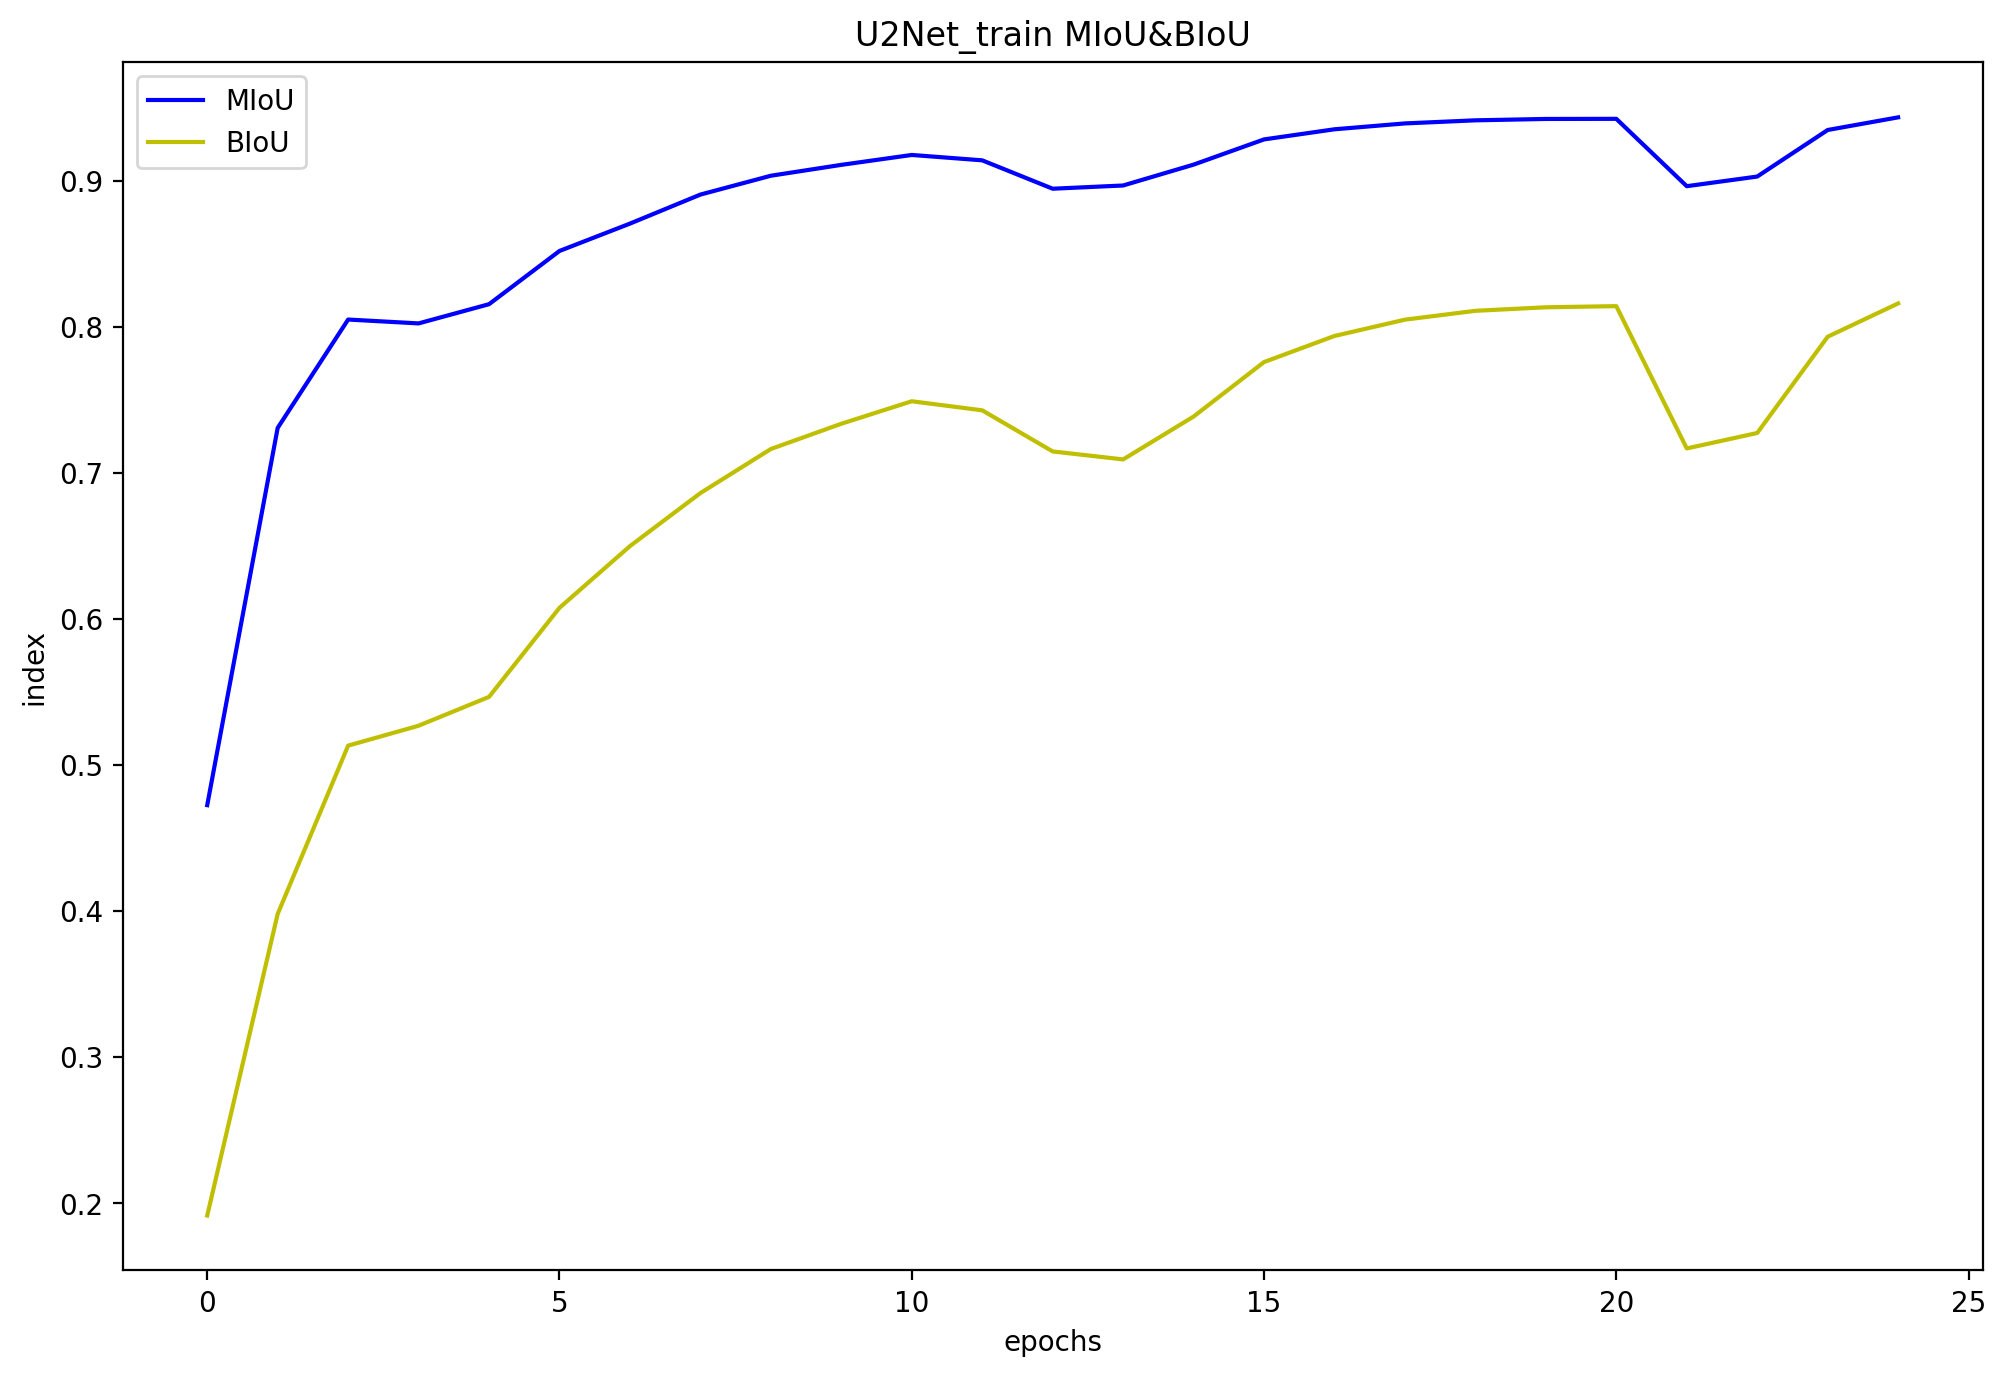

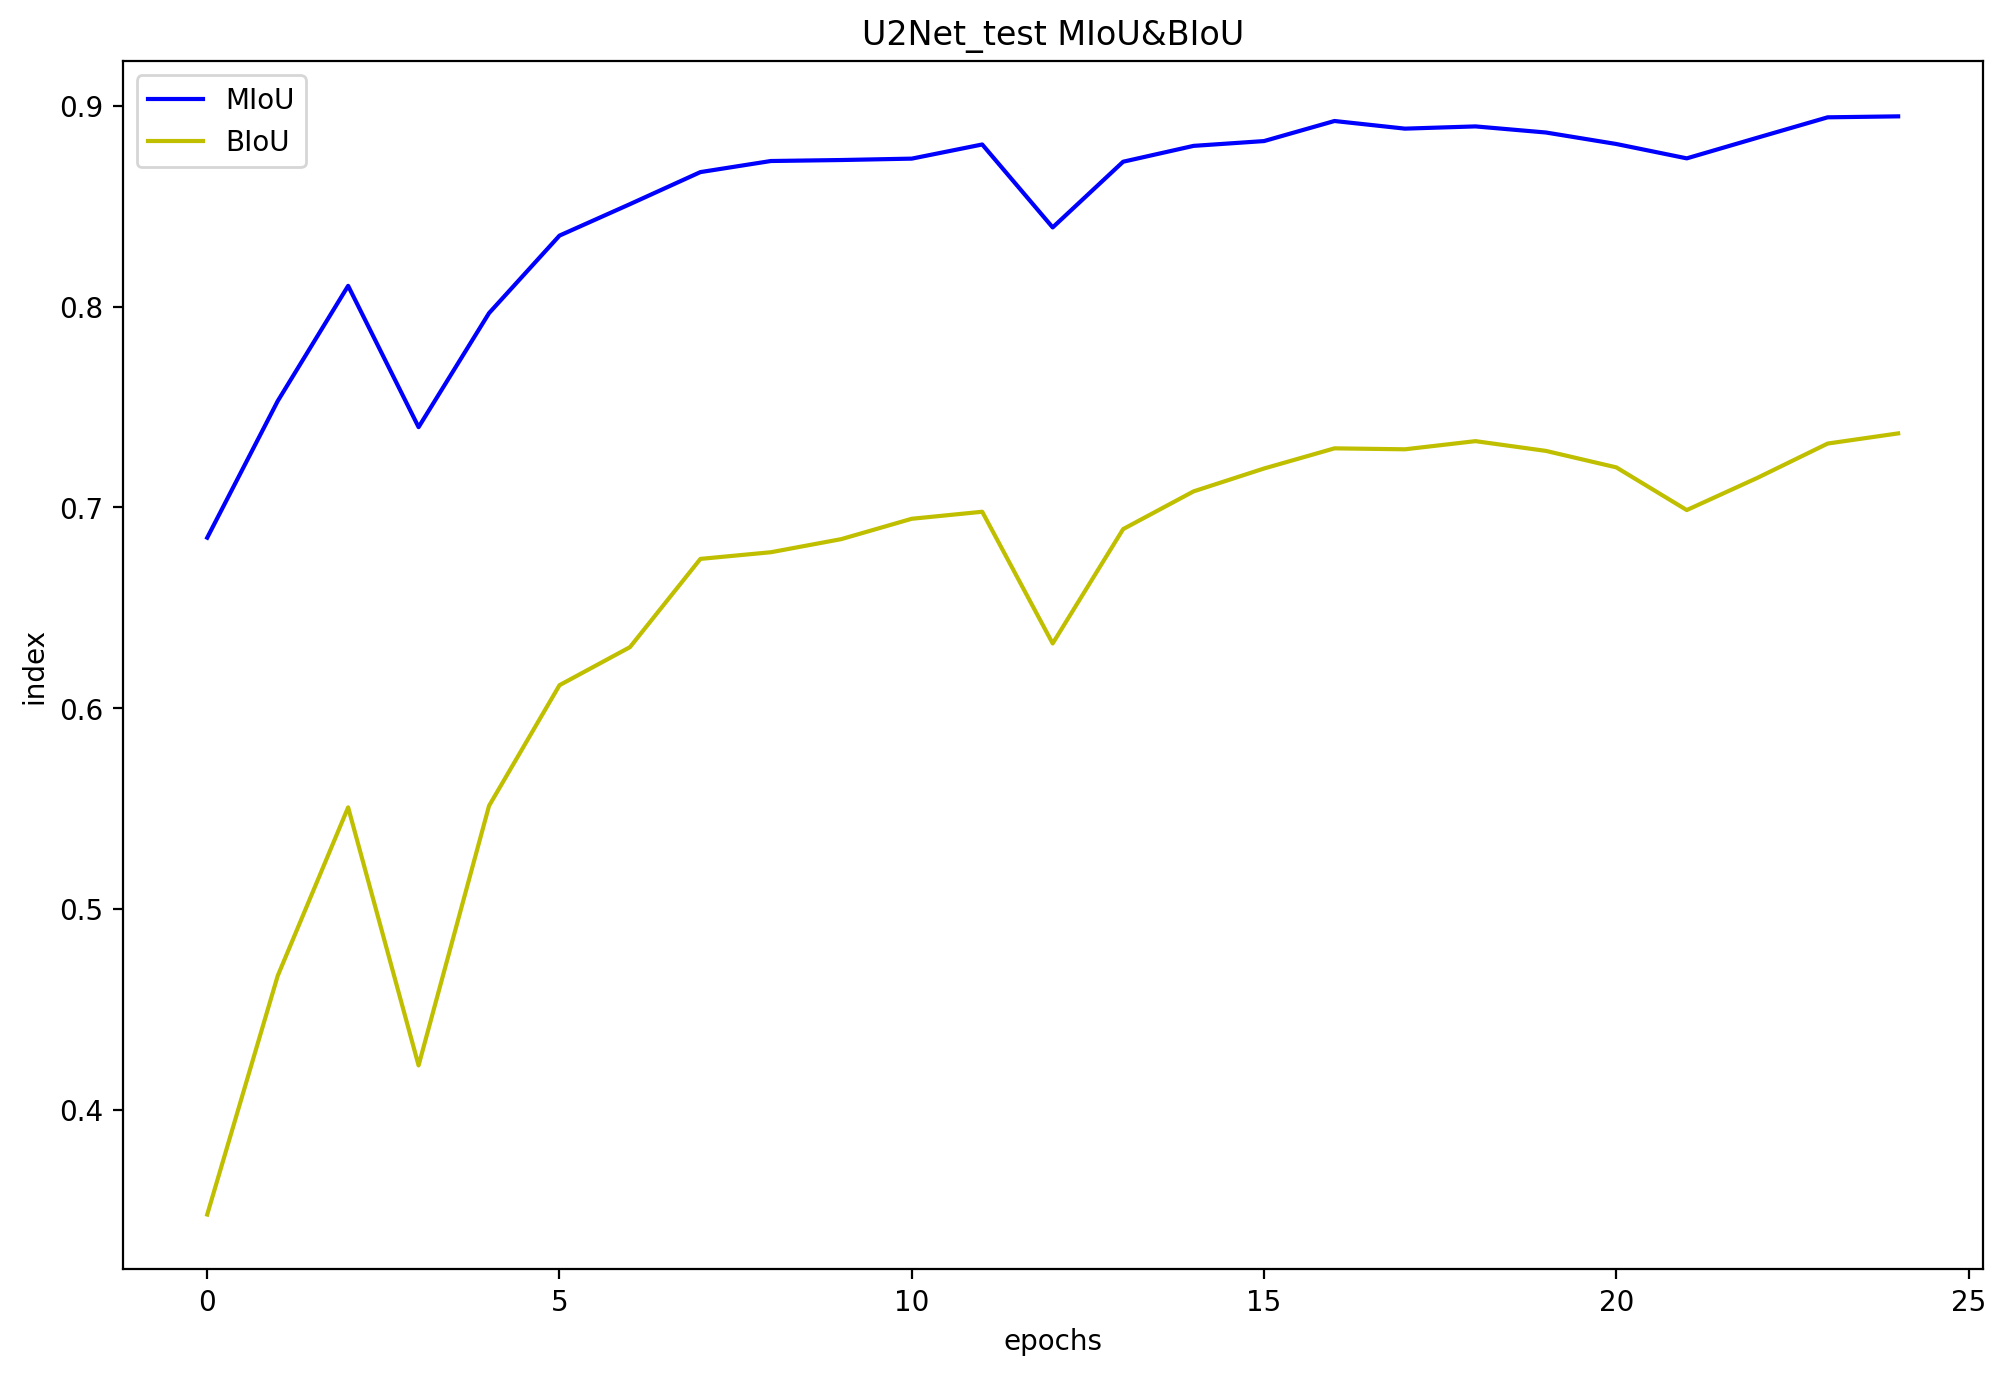

In [8]:
plt.figure(figsize=(12,8), dpi=200)
plt.xlabel('epochs')
plt.ylabel('index')
plt.title('U2Net_train MIoU&BIoU')
plt.plot(range(len(miou)),miou,color='b',label='MIoU')
plt.plot(range(len(biou)),biou,color='y',label='BIoU')
plt.legend()
plt.savefig('U2Net_train')

plt.figure(figsize=(12,8), dpi=200)
plt.xlabel('epochs')
plt.ylabel('index')
plt.title('U2Net_test MIoU&BIoU')
plt.plot(range(len(tmiou)),tmiou,color='b',label='MIoU')
plt.plot(range(len(tbiou)),tbiou,color='y',label='BIoU')
plt.legend()
plt.savefig('U2Net_test')

torch.Size([224, 224])


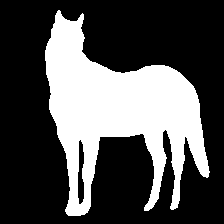

In [27]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
test=ty[1].squeeze(0).squeeze(0).cpu()
def toimg_RGB(v1):
    nimg = v1.transpose(1,2,0)
    print(nimg.shape)
    img = nimg * 255 # 将原来tensor里0-1的数值乘以255，以便转为uint8数据形式，uint8是图片的数值形式。
    img=Image.fromarray(np.uint8(img))
    return img
def toimg_Gray(v1):
    nimg = v1.round()
    print(nimg.shape)
    img = nimg * 255 # 将原来tensor里0-1的数值乘以255，以便转为uint8数据形式，uint8是图片的数值形式。
    img=Image.fromarray(np.uint8(img))
    return img
im1=toimg_Gray(test.detach())
im1